### Setup

In [29]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample

# Seaborn base theme
sns.set_theme(
    context="paper",  # 'paper' = smaller, for journal figures
    style="whitegrid",  # clean background with subtle grid
    font="DejaVu Sans",  # use a consistent sans-serif (replace if needed)
    font_scale=1.4,  # scale up text a bit for readability
    rc={
        # Figure sizing
        "figure.figsize": (10, 8),  # in inches; adjust for single-column
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.linewidth": 1.0,
        "axes.labelpad": 8,
        "axes.grid": True,
        "grid.linewidth": 0.4,
        "grid.alpha": 0.6,
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "legend.frameon": False,
        "savefig.dpi": 300,
        "savefig.transparent": True,  # transparent background for vector exports
        "pdf.fonttype": 42,  # embed TrueType fonts (important for Illustrator)
        "ps.fonttype": 42,
    },
)

# Matplotlib tight layout by default
plt.rcParams.update({"figure.autolayout": True})

In [16]:
ANN_DATA_DIR = "../data/processed/anndata_combined"

human_adata = ad.read_h5ad("../data/processed/anndata_combined/human_combined.h5ad")
mouse_adata = ad.read_h5ad("../data/processed/anndata_combined/mouse_combined.h5ad")

N_BOOTSTRAPS = 1000  # Number of bootstrap iterations

In [17]:
# ensure adatas have unique var names
human_adata.var_names_make_unique()
mouse_adata.var_names_make_unique()

# remove vars with NaN values
human_adata = human_adata[:, ~np.isnan(human_adata.X).any(axis=0)]
mouse_adata = mouse_adata[:, ~np.isnan(mouse_adata.X).any(axis=0)]

human_adata.obs["infl_acute"].fillna(False, inplace=True)
mouse_adata.obs["infl_acute"].fillna(False, inplace=True)
human_adata.obs["infl_acute"] = human_adata.obs["infl_acute"].astype(bool)
mouse_adata.obs["infl_acute"] = mouse_adata.obs["infl_acute"].astype(bool)

human_adata.obs["infl_subacute"].fillna(False, inplace=True)
mouse_adata.obs["infl_subacute"].fillna(False, inplace=True)
human_adata.obs["infl_subacute"] = human_adata.obs["infl_subacute"].astype(bool)
mouse_adata.obs["infl_subacute"] = mouse_adata.obs["infl_subacute"].astype(bool)

human_adata.obs["infl_chronic"].fillna(False, inplace=True)
mouse_adata.obs["infl_chronic"].fillna(False, inplace=True)
human_adata.obs["infl_chronic"] = human_adata.obs["infl_chronic"].astype(bool)
mouse_adata.obs["infl_chronic"] = mouse_adata.obs["infl_chronic"].astype(bool)

/tmp/ipykernel_1885322/2874002539.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  human_adata.obs['infl_acute'].fillna(False, inplace=True)
/tmp/ipykernel_1885322/2874002539.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [18]:
def transform_adata_to_X_y_takao(adata):
    adata_sub = adata[~adata.obs["takao_status"].isna()].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = (
        adata_sub.obs["takao_status"]
        .map({"takao_inflamed": 1, "takao_control": 0})
        .values.astype(int)
    )
    return X, X_emb, y


def transform_adata_to_X_y_all(adata):
    X = adata.X.copy()
    X_emb = adata.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata.obs["group"].map({"inflammation": 1, "control": 0}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_acute(adata):
    adata_sub = adata[(adata.obs["group"] == "control") | (adata.obs["infl_acute"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_acute"].map({True: 1, False: 0}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_subacute(adata):
    adata_sub = adata[(adata.obs["group"] == "control") | (adata.obs["infl_subacute"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_subacute"].map({True: 1, False: 0}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_acute_and_subacute(adata):
    adata_sub = adata[
        (adata.obs["group"] == "control")
        | (adata.obs["infl_acute"])
        | (adata.obs["infl_subacute"])
    ].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = (
        (adata_sub.obs["infl_acute"] | adata_sub.obs["infl_subacute"])
        .map({True: 1, False: 0})
        .values.astype(int)
    )
    return X, X_emb, y


def transform_adata_to_X_y_chronic(adata):
    adata_sub = adata[(adata.obs["group"] == "control") | (adata.obs["infl_chronic"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_chronic"].map({True: 1, False: 0}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_acute_to_chronic(adata):
    adata_sub = adata[(adata.obs["infl_acute"]) | (adata.obs["infl_chronic"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_chronic"].map({True: 0, False: 1}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_acute_subacute_to_chronic(adata):
    adata_sub = adata[
        (adata.obs["infl_acute"]) | (adata.obs["infl_subacute"]) | (adata.obs["infl_chronic"])
    ].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_chronic"].map({True: 0, False: 1}).values.astype(int)
    return X, X_emb, y

In [6]:
def calculate_inflammation_vector(embeddings, labels):
    """Calculates the mean(inflamed) - mean(control) vector."""
    control_mask = labels == 0
    inflamed_mask = labels == 1

    if np.sum(control_mask) == 0 or np.sum(inflamed_mask) == 0:
        print("Warning: One class is missing. Cannot calculate vector.")
        return None

    mean_control = np.mean(embeddings[control_mask], axis=0)
    mean_inflamed = np.mean(embeddings[inflamed_mask], axis=0)

    # Ensure vectors are 2D arrays for cosine_similarity
    return (mean_inflamed - mean_control).reshape(1, -1)


def bootstrap_vector(embeddings, labels, n_bootstraps=20):
    """Generates bootstrapped inflammation vectors."""
    bootstrapped_vectors = []

    control_indices = np.where(labels == 0)[0]
    inflamed_indices = np.where(labels == 1)[0]

    original_vector = calculate_inflammation_vector(embeddings, labels)
    similarities = []

    print(f"Running {n_bootstraps} bootstraps...")
    for i in range(n_bootstraps):
        # Resample indices with replacement
        bs_control_indices = resample(control_indices)
        bs_inflamed_indices = resample(inflamed_indices)

        # Get bootstrapped embeddings
        bs_embeddings_control = embeddings[bs_control_indices]
        bs_embeddings_inflamed = embeddings[bs_inflamed_indices]

        # Calculate vector for this bootstrap sample
        mean_bs_control = np.mean(bs_embeddings_control, axis=0)
        mean_bs_inflamed = np.mean(bs_embeddings_inflamed, axis=0)
        bs_vector = (mean_bs_inflamed - mean_bs_control).reshape(1, -1)

        bootstrapped_vectors.append(bs_vector)

        # Calculate similarity to the original vector
        sim = cosine_similarity(original_vector, bs_vector)[0][0]
        similarities.append(sim)

    return bootstrapped_vectors, similarities


def plot_vector_stability(human_sims, mouse_sims):
    print("Plotting stability distributions...")
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    plt.subplot(1, 2, 1)
    sns.histplot(human_sims)
    mean_sim_human = np.mean(human_sims)
    plt.axvline(
        mean_sim_human, color="r", linestyle="--", label=f"Mean Sim = {mean_sim_human:.3f}"
    )
    plt.title("Human Inflammation Vector Stability")
    plt.xlabel("Cosine Similarity to Original Vector")
    plt.ylabel("Frequency")
    plt.xlim(min(human_sims), max(human_sims))
    plt.legend()

    # Plot Mouse Stability
    plt.subplot(1, 2, 2)
    sns.histplot(mouse_sims)
    mean_sim_mouse = np.mean(mouse_sims)
    plt.axvline(
        mean_sim_mouse, color="r", linestyle="--", label=f"Mean Sim = {mean_sim_mouse:.3f}"
    )
    plt.title("Mouse Inflammation Vector Stability")
    plt.xlabel("Cosine Similarity to Original Vector")
    plt.ylabel("Frequency")
    plt.xlim(min(mouse_sims), max(mouse_sims))
    plt.legend()
    plt.tight_layout()
    plt.show()

### All comparison


Cosine Similarity between Human and Mouse Original Vectors: 0.0506
Running 1000 bootstraps...
Running 1000 bootstraps...
Plotting stability distributions...


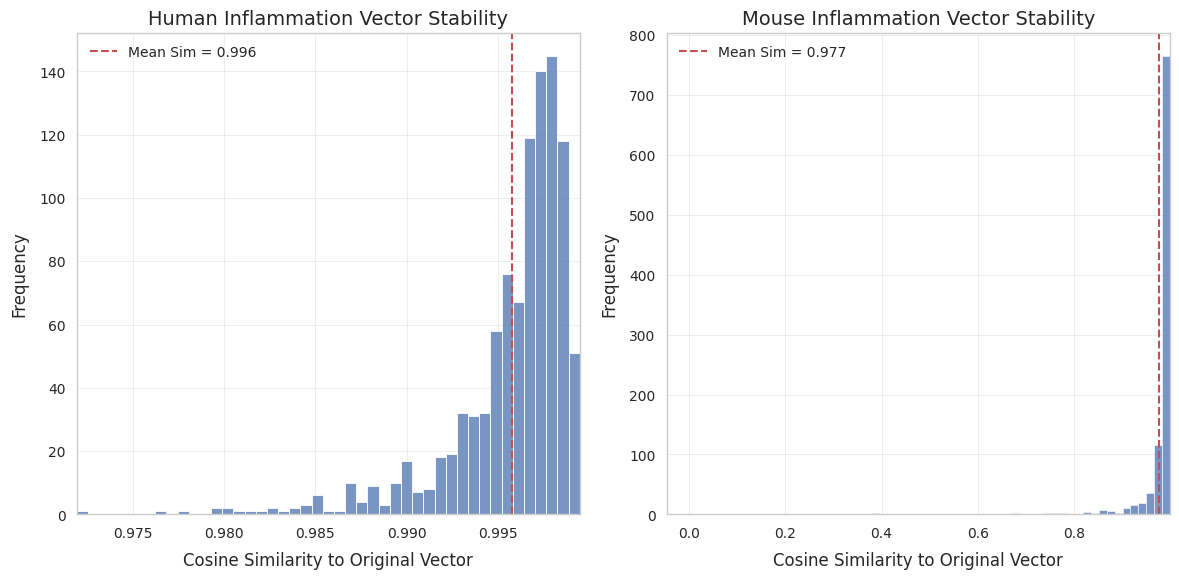

In [19]:
X_human, X_emb_human, y_human = transform_adata_to_X_y_all(human_adata)
X_mouse, X_emb_mouse, y_mouse = transform_adata_to_X_y_all(mouse_adata)

vec_human_orig = calculate_inflammation_vector(X_emb_human, y_human)
vec_mouse_orig = calculate_inflammation_vector(X_emb_mouse, y_mouse)

cross_species_sim = cosine_similarity(vec_human_orig, vec_mouse_orig)[0][0]
print(f"\nCosine Similarity between Human and Mouse Original Vectors: {cross_species_sim:.4f}")
# Run bootstrapping for human and mouse
human_bs_vectors, human_bs_similarities = bootstrap_vector(
    X_emb_human, y_human, n_bootstraps=N_BOOTSTRAPS
)
mouse_bs_vectors, mouse_bs_similarities = bootstrap_vector(
    X_emb_mouse, y_mouse, n_bootstraps=N_BOOTSTRAPS
)

plot_vector_stability(human_bs_similarities, mouse_bs_similarities)

### Takao comparison


Cosine Similarity between Human and Mouse Original Vectors: 0.0624
Running 1000 bootstraps...
Running 1000 bootstraps...
Plotting stability distributions...


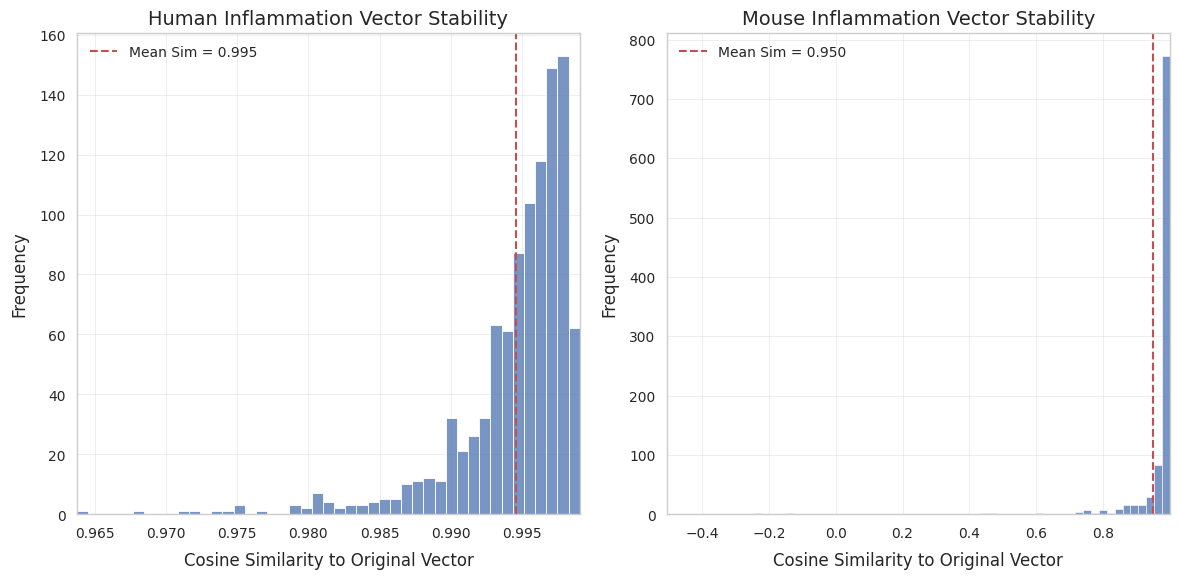

In [ ]:
X_human, X_emb_human, y_human = transform_adata_to_X_y_takao(human_adata)
X_mouse, X_emb_mouse, y_mouse = transform_adata_to_X_y_takao(mouse_adata)

vec_human_orig = calculate_inflammation_vector(X_emb_human, y_human)
vec_mouse_orig = calculate_inflammation_vector(X_emb_mouse, y_mouse)

cross_species_sim = cosine_similarity(vec_human_orig, vec_mouse_orig)[0][0]
print(f"\nCosine Similarity between Human and Mouse Original Vectors: {cross_species_sim:.4f}")
# Run bootstrapping for human and mouse
human_bs_vectors, human_bs_similarities = bootstrap_vector(
    X_emb_human, y_human, n_bootstraps=N_BOOTSTRAPS
)
mouse_bs_vectors, mouse_bs_similarities = bootstrap_vector(
    X_emb_mouse, y_mouse, n_bootstraps=N_BOOTSTRAPS
)

plot_vector_stability(human_bs_similarities, mouse_bs_similarities)

### Acute inflammation comparison

(374, 640) (374,) (137, 640) (137,)

Cosine Similarity between Human and Mouse Original Vectors: -0.0738
Running 1000 bootstraps...
Running 1000 bootstraps...
Plotting stability distributions...


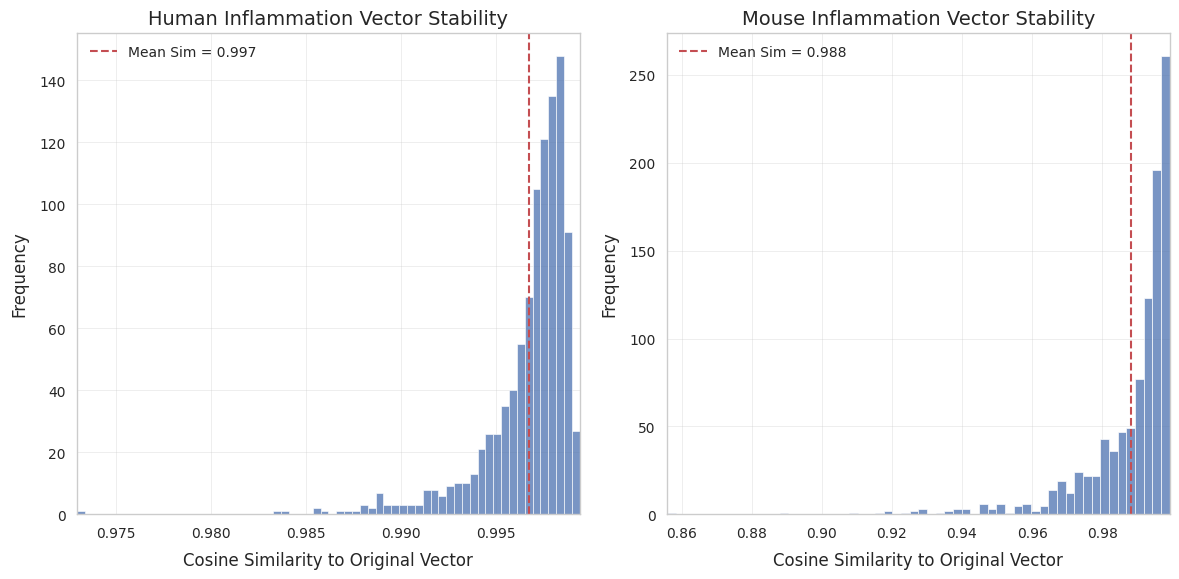

In [ ]:
X_human, X_emb_human, y_human = transform_adata_to_X_y_acute(human_adata)
X_mouse, X_emb_mouse, y_mouse = transform_adata_to_X_y_acute(mouse_adata)

print(X_emb_human.shape, y_human.shape, X_emb_mouse.shape, y_mouse.shape)

vec_human_orig = calculate_inflammation_vector(X_emb_human, y_human)
vec_mouse_orig = calculate_inflammation_vector(X_emb_mouse, y_mouse)

cross_species_sim = cosine_similarity(vec_human_orig, vec_mouse_orig)[0][0]
print(f"\nCosine Similarity between Human and Mouse Original Vectors: {cross_species_sim:.4f}")
# Run bootstrapping for human and mouse
human_bs_vectors, human_bs_similarities = bootstrap_vector(
    X_emb_human, y_human, n_bootstraps=N_BOOTSTRAPS
)
mouse_bs_vectors, mouse_bs_similarities = bootstrap_vector(
    X_emb_mouse, y_mouse, n_bootstraps=N_BOOTSTRAPS
)

plot_vector_stability(human_bs_similarities, mouse_bs_similarities)

### Subacute inflammation comparison

(629, 640) (629,) (133, 640) (133,)

Cosine Similarity between Human and Mouse Original Vectors: 0.0195
Running 1000 bootstraps...
Running 1000 bootstraps...
Plotting stability distributions...


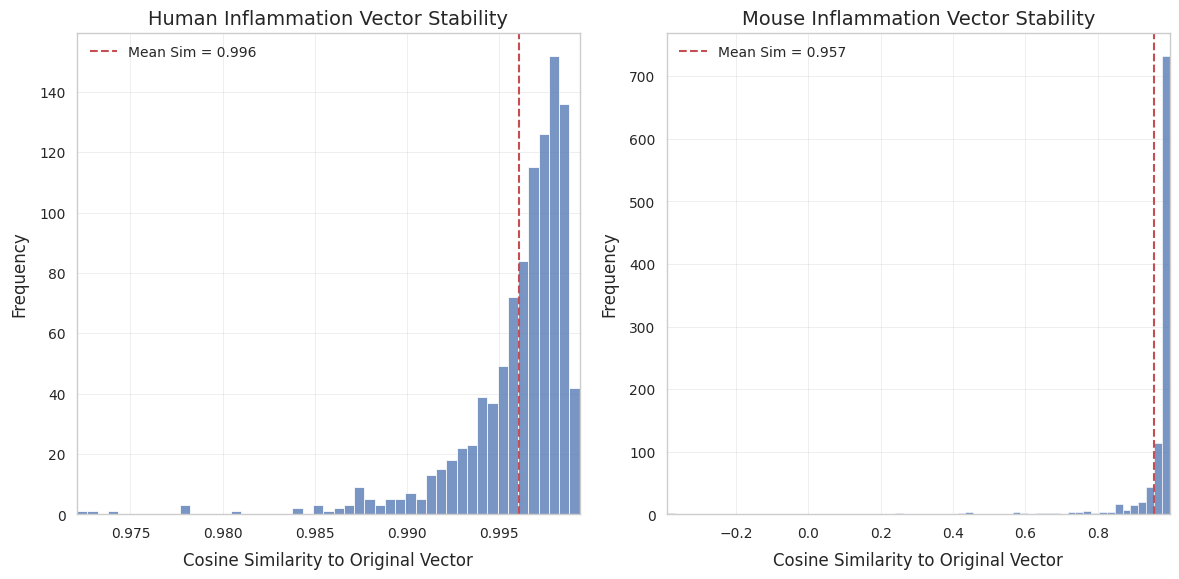

In [ ]:
X_human, X_emb_human, y_human = transform_adata_to_X_y_subacute(human_adata)
X_mouse, X_emb_mouse, y_mouse = transform_adata_to_X_y_subacute(mouse_adata)

print(X_emb_human.shape, y_human.shape, X_emb_mouse.shape, y_mouse.shape)

vec_human_orig = calculate_inflammation_vector(X_emb_human, y_human)
vec_mouse_orig = calculate_inflammation_vector(X_emb_mouse, y_mouse)

cross_species_sim = cosine_similarity(vec_human_orig, vec_mouse_orig)[0][0]
print(f"\nCosine Similarity between Human and Mouse Original Vectors: {cross_species_sim:.4f}")
# Run bootstrapping for human and mouse
human_bs_vectors, human_bs_similarities = bootstrap_vector(
    X_emb_human, y_human, n_bootstraps=N_BOOTSTRAPS
)
mouse_bs_vectors, mouse_bs_similarities = bootstrap_vector(
    X_emb_mouse, y_mouse, n_bootstraps=N_BOOTSTRAPS
)

plot_vector_stability(human_bs_similarities, mouse_bs_similarities)

### Chronic inflammation comparison

(652, 640) (652,) (162, 640) (162,)

Cosine Similarity between Human and Mouse Original Vectors: 0.0543
Running 1000 bootstraps...
Running 1000 bootstraps...
Plotting stability distributions...


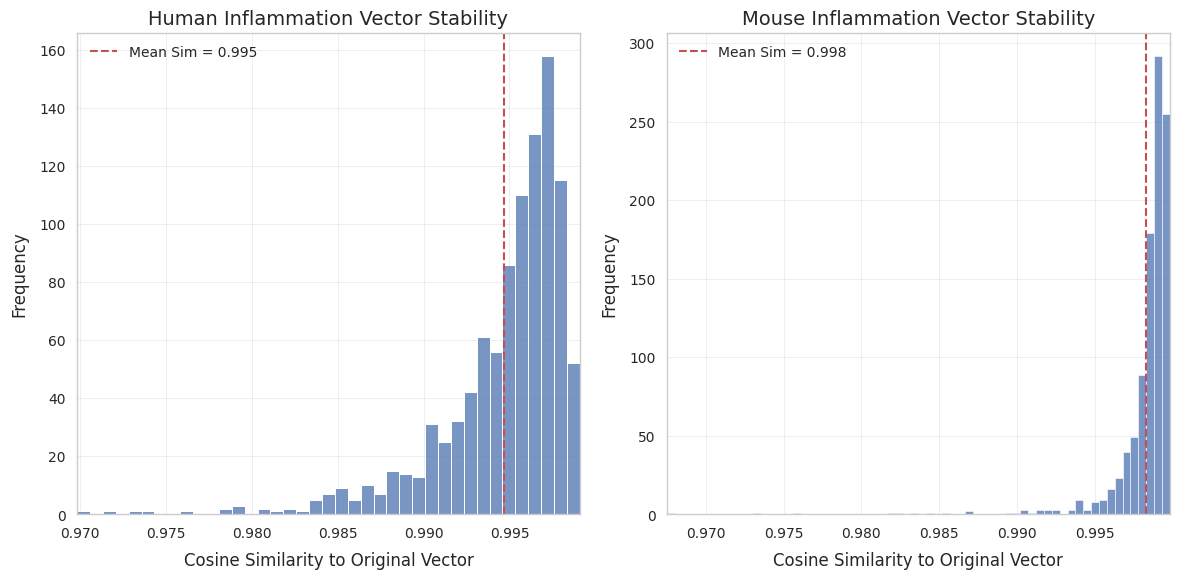

In [ ]:
X_human, X_emb_human, y_human = transform_adata_to_X_y_chronic(human_adata)
X_mouse, X_emb_mouse, y_mouse = transform_adata_to_X_y_chronic(mouse_adata)

print(X_emb_human.shape, y_human.shape, X_emb_mouse.shape, y_mouse.shape)

vec_human_orig = calculate_inflammation_vector(X_emb_human, y_human)
vec_mouse_orig = calculate_inflammation_vector(X_emb_mouse, y_mouse)

cross_species_sim = cosine_similarity(vec_human_orig, vec_mouse_orig)[0][0]
print(f"\nCosine Similarity between Human and Mouse Original Vectors: {cross_species_sim:.4f}")
# Run bootstrapping for human and mouse
human_bs_vectors, human_bs_similarities = bootstrap_vector(
    X_emb_human, y_human, n_bootstraps=N_BOOTSTRAPS
)
mouse_bs_vectors, mouse_bs_similarities = bootstrap_vector(
    X_emb_mouse, y_mouse, n_bootstraps=N_BOOTSTRAPS
)

plot_vector_stability(human_bs_similarities, mouse_bs_similarities)

### Acute + subacute vs chronic inflammation comparison

(838, 640) (838,) (117, 640) (117,)

Cosine Similarity between Human and Mouse Original Vectors: -0.1156
Running 1000 bootstraps...
Running 1000 bootstraps...
Plotting stability distributions...


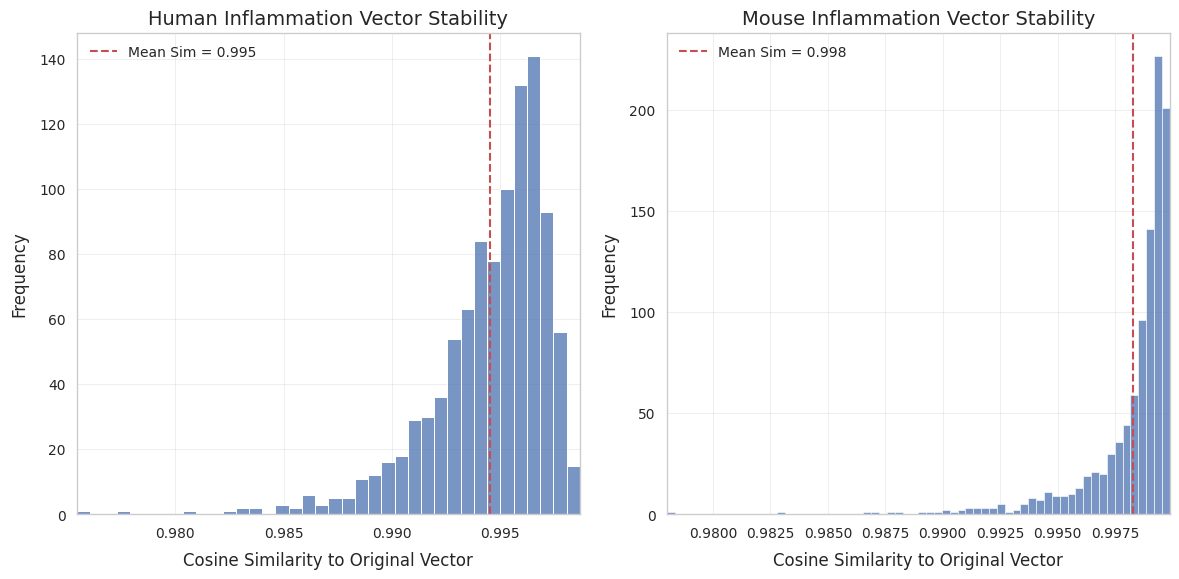

In [ ]:
X_human, X_emb_human, y_human = transform_adata_to_X_y_acute_to_chronic(human_adata)
X_mouse, X_emb_mouse, y_mouse = transform_adata_to_X_y_acute_to_chronic(mouse_adata)

print(X_emb_human.shape, y_human.shape, X_emb_mouse.shape, y_mouse.shape)

vec_human_orig = calculate_inflammation_vector(X_emb_human, y_human)
vec_mouse_orig = calculate_inflammation_vector(X_emb_mouse, y_mouse)

cross_species_sim = cosine_similarity(vec_human_orig, vec_mouse_orig)[0][0]
print(f"\nCosine Similarity between Human and Mouse Original Vectors: {cross_species_sim:.4f}")
# Run bootstrapping for human and mouse
human_bs_vectors, human_bs_similarities = bootstrap_vector(
    X_emb_human, y_human, n_bootstraps=N_BOOTSTRAPS
)
mouse_bs_vectors, mouse_bs_similarities = bootstrap_vector(
    X_emb_mouse, y_mouse, n_bootstraps=N_BOOTSTRAPS
)

plot_vector_stability(human_bs_similarities, mouse_bs_similarities)

(1373, 640) (1373,) (159, 640) (159,)

Cosine Similarity between Human and Mouse Original Vectors: -0.1225
Running 1000 bootstraps...
Running 1000 bootstraps...
Plotting stability distributions...


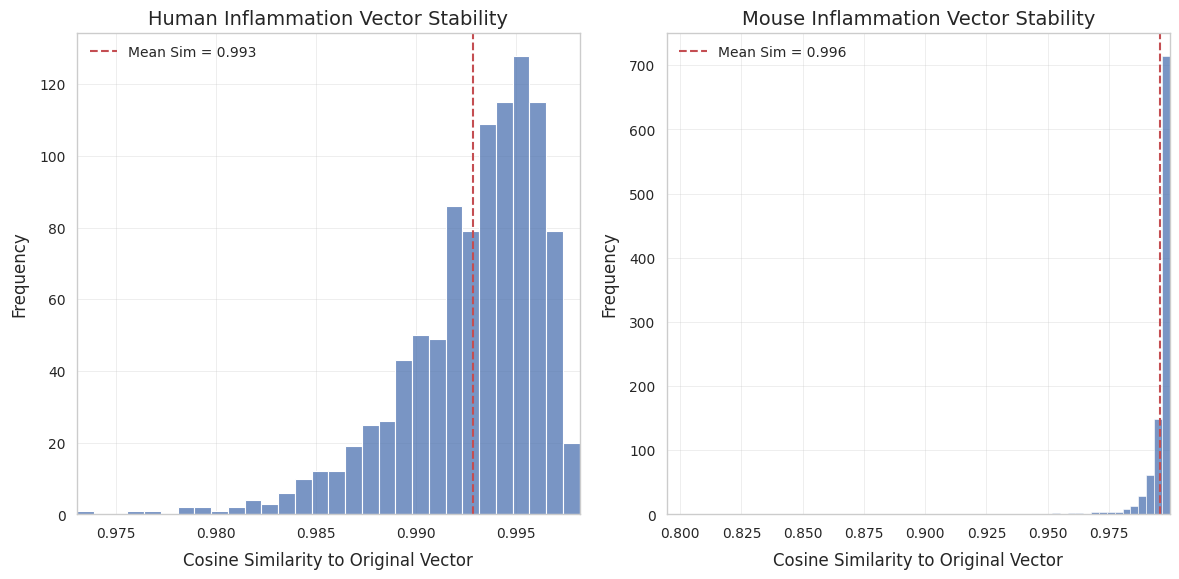

In [ ]:
X_human, X_emb_human, y_human = transform_adata_to_X_y_acute_subacute_to_chronic(human_adata)
X_mouse, X_emb_mouse, y_mouse = transform_adata_to_X_y_acute_subacute_to_chronic(mouse_adata)

print(X_emb_human.shape, y_human.shape, X_emb_mouse.shape, y_mouse.shape)

vec_human_orig = calculate_inflammation_vector(X_emb_human, y_human)
vec_mouse_orig = calculate_inflammation_vector(X_emb_mouse, y_mouse)

cross_species_sim = cosine_similarity(vec_human_orig, vec_mouse_orig)[0][0]
print(f"\nCosine Similarity between Human and Mouse Original Vectors: {cross_species_sim:.4f}")
# Run bootstrapping for human and mouse
human_bs_vectors, human_bs_similarities = bootstrap_vector(
    X_emb_human, y_human, n_bootstraps=N_BOOTSTRAPS
)
mouse_bs_vectors, mouse_bs_similarities = bootstrap_vector(
    X_emb_mouse, y_mouse, n_bootstraps=N_BOOTSTRAPS
)

plot_vector_stability(human_bs_similarities, mouse_bs_similarities)

### Combining into a similarity matrix

In [21]:
# create a matrix with vector similarities for all setups, with confidence intervals using the bootstrap results, it should extrapolate columns for mouse, human, and compare each setup across both species (ex: acute human vs acute mouse, subacute human vs subacute mouse, acute human vs. subacute mouse, etc.)
similarity_matrix = pd.DataFrame(
    columns=["Human_Setup", "Mouse_Setup", "Cosine_Similarity", "CI_Lower", "CI_Upper"]
)
setups = [
    ("All", transform_adata_to_X_y_all),
    ("Takao", transform_adata_to_X_y_takao),
    ("Acute", transform_adata_to_X_y_acute),
    ("Subacute", transform_adata_to_X_y_subacute),
    ("Chronic", transform_adata_to_X_y_chronic),
    ("Acute_to_Chronic", transform_adata_to_X_y_acute_to_chronic),
]

records = []

for human_setup_name, human_transform in setups:
    X_human, X_emb_human, y_human = human_transform(human_adata)
    vec_human_orig = calculate_inflammation_vector(X_emb_human, y_human)
    human_bs_vectors, human_bs_similarities = bootstrap_vector(
        X_emb_human, y_human, n_bootstraps=N_BOOTSTRAPS
    )

    for mouse_setup_name, mouse_transform in setups:
        X_mouse, X_emb_mouse, y_mouse = mouse_transform(mouse_adata)
        vec_mouse_orig = calculate_inflammation_vector(X_emb_mouse, y_mouse)
        cross_species_sim = cosine_similarity(vec_human_orig, vec_mouse_orig)[0][0]

        mouse_bs_vectors, mouse_bs_similarities = bootstrap_vector(
            X_emb_mouse, y_mouse, n_bootstraps=N_BOOTSTRAPS
        )

        # Vectorized CI
        human_bs_array = np.vstack(human_bs_vectors)
        mouse_bs_array = np.vstack(mouse_bs_vectors)
        human_bs_array /= np.linalg.norm(human_bs_array, axis=1, keepdims=True)
        mouse_bs_array /= np.linalg.norm(mouse_bs_array, axis=1, keepdims=True)
        combined_sims_flat = (human_bs_array @ mouse_bs_array.T).flatten()
        ci_lower = np.percentile(combined_sims_flat, 2.5)
        ci_upper = np.percentile(combined_sims_flat, 97.5)

        # Append to list of records
        records.append(
            {
                "Human_Setup": human_setup_name,
                "Mouse_Setup": mouse_setup_name,
                "Cosine_Similarity": cross_species_sim,
                "CI_Lower": ci_lower,
                "CI_Upper": ci_upper,
            }
        )

similarity_matrix = pd.DataFrame(records)

Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
Running 1000 bootstraps...
R

In [22]:
similarity_matrix

,Human_Setup,Mouse_Setup,Cosine_Similarity,CI_Lower,CI_Upper
0,All,All,0.050611,0.011315,0.089453
1,All,Takao,0.051054,0.014355,0.109830
2,All,Acute,-0.032287,-0.076345,0.013943
3,All,Subacute,0.032791,-0.018397,0.063179
4,All,Acute_and_Subacute,-0.007851,-0.075673,0.062932
...,...,...,...,...,...
59,Acute_Subacute_to_Chronic,Subacute,-0.057470,-0.234649,0.009098
60,Acute_Subacute_to_Chronic,Acute_and_Subacute,-0.279003,-0.313305,-0.145930
61,Acute_Subacute_to_Chronic,Chronic,0.041490,0.014762,0.072697
62,Acute_Subacute_to_Chronic,Acute_to_Chronic,-0.114379,-0.149853,-0.080361


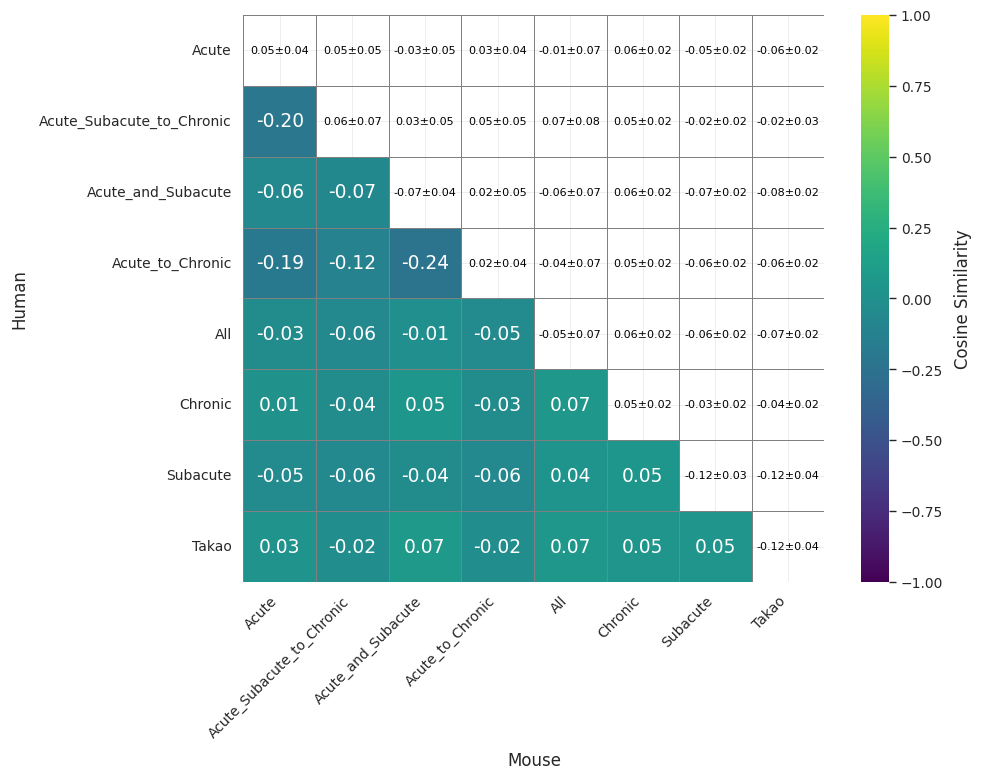

In [28]:
import numpy as np
import pandas as pd

# Assume similarity_matrix has columns: Human_Setup, Mouse_Setup, Cosine_Similarity, CI_Lower, CI_Upper
labels_human = similarity_matrix["Human_Setup"].unique()
labels_mouse = similarity_matrix["Mouse_Setup"].unique()

# Pivot matrices
cosine_mat = similarity_matrix.pivot(
    index="Human_Setup", columns="Mouse_Setup", values="Cosine_Similarity"
)
ci_lower_mat = similarity_matrix.pivot(
    index="Human_Setup", columns="Mouse_Setup", values="CI_Lower"
)
ci_upper_mat = similarity_matrix.pivot(
    index="Human_Setup", columns="Mouse_Setup", values="CI_Upper"
)

mask_upper = np.triu(np.ones_like(cosine_mat, dtype=bool))
mask_lower = np.tril(np.ones_like(cosine_mat, dtype=bool))

# Lower triangle: cosine similarity
sns.heatmap(
    cosine_mat,
    mask=mask_upper,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "Cosine Similarity"},
    linewidths=0.5,
    linecolor="gray",
    vmin=-1,
    vmax=1,
)

# Upper triangle: CI in ± format
for i, human in enumerate(labels_human):
    for j, mouse in enumerate(labels_mouse):
        if i <= j:  # upper triangle
            center = cosine_mat.loc[human, mouse]
            half_width = (ci_upper_mat.loc[human, mouse] - ci_lower_mat.loc[human, mouse]) / 2
            ci_text = f"{center:.2f}±{half_width:.2f}"
            plt.text(
                j + 0.5, i + 0.5, ci_text, ha="center", va="center", fontsize=8, color="black"
            )

plt.xlabel("Mouse", fontsize=12)
plt.ylabel("Human", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()